In [3]:
import pandas as pd

In [4]:
client_train = pd.read_csv('client_train.csv')
invoice_train = pd.read_csv('invoice_train.csv')

client_test = pd.read_csv('client_test.csv')
invoice_test = pd.read_csv('invoice_test.csv')
sample_submission = pd.read_csv('SampleSubmission.csv')

C:\Users\Reinhard\AppData\Local\Temp\ipykernel_12756\374779496.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  invoice_train = pd.read_csv('invoice_train.csv')


In [4]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [5]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [6]:
#encode labels in categorical column
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)
invoice_test['counter_type']=invoice_test['counter_type'].map(d)

In [7]:
#convert categorical columns to int for model
client_train['client_catg'] = client_train['client_catg'].astype(int)
client_train['disrict'] = client_train['disrict'].astype(int)

client_test['client_catg'] = client_test['client_catg'].astype(int)
client_test['disrict'] = client_test['disrict'].astype(int)

In [8]:
def aggregate_by_client_id(invoice_data):
    aggs = {}
    aggs['consommation_level_1'] = ['mean']
    aggs['consommation_level_2'] = ['mean']
    aggs['consommation_level_3'] = ['mean']
    aggs['consommation_level_4'] = ['mean']

    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='{}transactions_count'.format('1')))
    return pd.merge(df, agg_trans, on='client_id', how='left')

In [9]:
#group invoice data by client_id
agg_train = aggregate_by_client_id(invoice_train)

In [10]:
print(agg_train.shape)
agg_train.head()

(135493, 6)


,client_id,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,train_Client_0,35,352.400000,10.571429,0.000000,0.000000
1,train_Client_1,37,557.540541,0.000000,0.000000,0.000000
2,train_Client_10,18,798.611111,37.888889,0.000000,0.000000
3,train_Client_100,20,1.200000,0.000000,0.000000,0.000000
4,train_Client_1000,14,663.714286,104.857143,117.357143,36.714286


In [11]:
#merge aggregate data with client dataset
train = pd.merge(client_train,agg_train, on='client_id', how='left')

In [12]:
#aggregate test set
agg_test = aggregate_by_client_id(invoice_test)
test = pd.merge(client_test,agg_test, on='client_id', how='left')

In [13]:
train.shape, test.shape

((135493, 11), (58069, 10))

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   disrict                    135493 non-null  int32  
 1   client_id                  135493 non-null  object 
 2   client_catg                135493 non-null  int32  
 3   region                     135493 non-null  int64  
 4   creation_date              135493 non-null  object 
 5   target                     135493 non-null  float64
 6   1transactions_count        135493 non-null  int64  
 7   consommation_level_1_mean  135493 non-null  float64
 8   consommation_level_2_mean  135493 non-null  float64
 9   consommation_level_3_mean  135493 non-null  float64
 10  consommation_level_4_mean  135493 non-null  float64
dtypes: float64(5), int32(2), int64(2), object(2)
memory usage: 10.3+ MB


In [20]:
#drop redundant columns
sub_client_id = test['client_id']
drop_columns = ['client_id', 'creation_date']

for col in drop_columns:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [21]:
# Assume train_data and test_data are already merged and preprocessed
# Preprocessing categorical columns
# Drop unnecessary columns
# Split features and target
X = train.drop(columns=["target"])
y = train["target"]

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(test)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



In [23]:
X_train.shape

(108394, 8)

In [18]:
from imblearn.over_sampling import SMOTE

X = X_train  # Features
y = y_train              # Target column

# Applying SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)  # 'auto' balances the classes equally
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Original target distribution:\n{y_train.value_counts()}")
print(f"Resampled target distribution:\n{y_resampled.value_counts()}")


Original target distribution:
target
0.0    102392
1.0      6002
Name: count, dtype: int64
Resampled target distribution:
target
0.0    102392
1.0    102392
Name: count, dtype: int64


In [ ]:
# Build the neural network model
model = Sequential([
    Dense(64, activation="selu", input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(32, activation="selu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["AUC"])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_auc", mode = 'max', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_resampled, y_resampled,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the validation set
val_loss, val_auc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation AUC: {val_auc:.4f}")


c:\Users\Reinhard\anaconda3\envs\Datascience\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - AUC: 0.6836 - loss: 0.6441 - val_AUC: 0.7268 - val_loss: 0.6120
Epoch 2/50
   1/6400 ━━━━━━━━━━━━━━━━━━━━ 13:58 131ms/step - AUC: 0.6745 - loss: 0.6332

c:\Users\Reinhard\anaconda3\envs\Datascience\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss
  current = self.get_monitor_value(logs)


6400/6400 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - AUC: 0.7098 - loss: 0.6168 - val_AUC: 0.7347 - val_loss: 0.6056
Epoch 3/50
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - AUC: 0.7188 - loss: 0.6105 - val_AUC: 0.7369 - val_loss: 0.6041
Epoch 4/50
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - AUC: 0.7213 - loss: 0.6088 - val_AUC: 0.7367 - val_loss: 0.6198
Epoch 5/50
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - AUC: 0.7266 - loss: 0.6056 - val_AUC: 0.7391 - val_loss: 0.6020
Epoch 6/50
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - AUC: 0.7295 - loss: 0.6038 - val_AUC: 0.7411 - val_loss: 0.6094
Epoch 7/50
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - AUC: 0.7272 - loss: 0.6053 - val_AUC: 0.7400 - val_loss: 0.5711
Epoch 8/50
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - AUC: 0.7298 - loss: 0.6039 - val_AUC: 0.7403 - val_loss: 0.6047
Epoch 9/50
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - AUC: 0.7310 - loss: 0.6031 - val_AUC: 0.7430 - val_loss: 0.5912
Epoch 10/50
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 

In [21]:
# Make predictions on the test set
test_predictions = model.predict(X_test).flatten()

# Prepare submission file
submission = pd.DataFrame({
    "client_id": client_test["client_id"],  # Assuming `client_test` contains this column
    "target": np.round(test_predictions, 1)
})
submission.to_csv("submission_152epochs.csv", index=False)
print("Submission file saved as 'submission_ann.csv'")


1815/1815 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Submission file saved as 'submission_ann.csv'


In [ ]:
submission.head()

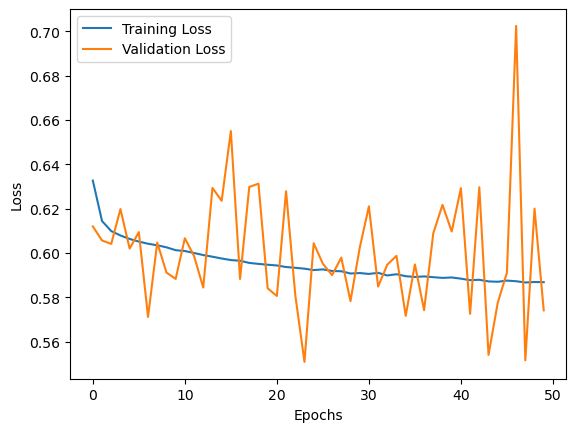

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
